In [3]:
import torch

In [4]:
import h5py
import numpy as np
import json
import os
import cv2
from pytransform3d.transform_manager import TransformManager
import matplotlib.pyplot as plt
import kornia
import skimage

import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix
from torchmetrics import ConfusionMatrix

## Numpy code transform + Addition uncertainty

In [4]:
files_directory = '../learning_blenerproc/images_pose_robocup/'
filenames = [f for f in sorted(os.listdir(files_directory)) if os.path.isfile(os.path.join(files_directory, f))]


In [5]:
def give_rotation_translation(old_pose, new_pose):
    tm = TransformManager()
    tm.add_transform("world", "old_pose", old_pose)
    tm.add_transform("world", "new_pose", new_pose)
    new2old = tm.get_transform("old_pose", "new_pose")
    return new2old

def transform_segmask(cam_matrix, old_pose, new_pose, old_seg, old_depth):
    height, width = old_depth.shape

    f = cam_matrix[0]
    K = np.array(cam_matrix).reshape(3,3)
    Kinv= np.linalg.inv(K)
    
    R_and_T = give_rotation_translation(old_pose, new_pose)

    R = R_and_T[:3,:3]
    T = R_and_T[:3,3].reshape(3,1)

    
    x = np.arange(height)
    y = np.arange(width)

    # full coorindate arrays
    xx, yy = np.meshgrid(x, y, indexing='ij')
    xx = xx.reshape(height*width)
    yy = yy.reshape(height*width)

    ## Stacking to make the matrix 3 x points
    pts = np.vstack((xx, yy, np.ones_like(xx)))
    
    ravelFilledDepth = old_depth.reshape(height*width)

    new_pt = K.dot(R).dot(Kinv).dot(pts) + K.dot(T/ravelFilledDepth)
    new_pt = new_pt / new_pt[2][:]
    new_pt = new_pt.round().astype(int)
    new_pt = new_pt.clip(min=0, max=511)
    
    dst = -1*np.ones_like(old_seg)
    print ("dst ", dst.shape )
    print ("old_seg ", old_seg.shape )
    
    dst[new_pt[0], new_pt[1], :] = old_seg[xx, yy, : ]
    for i in range(old_seg.shape[-1]):
        temp_dst = skimage.measure.block_reduce(dst[:,:,i], (2,2), np.max)
        dst[:,:,i] = skimage.transform.resize(temp_dst, (height,width),
                           anti_aliasing=True)

    
    return dst

in
######  0000
image shape  (512, 512, 3)
mask shape  (512, 512)
depth  shape  (512, 512)
Keys: <KeysViewHDF5 ['blender_proc_version', 'camera_pose', 'class_segmaps', 'colors', 'depth']>
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[-0.16820133]
 [ 0.31069955]
 [ 0.83613789]]
Img shape  (512, 512, 3)
Img shape  (3, 512, 512)
 model output shape  (512, 512, 8)
######  0001
image shape  (512, 512, 3)
mask shape  (512, 512)
depth  shape  (512, 512)
Keys: <KeysViewHDF5 ['blender_proc_version', 'camera_pose', 'class_segmaps', 'colors', 'depth']>
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[-0.16684097]
 [ 0.31087378]
 [ 0.58589488]]
Img shape  (512, 512, 3)
Img shape  (3, 512, 512)
 model output shape  (512, 512, 8)
call
dst  (512, 512, 8)
old_seg  (512, 512, 8)
added dst shape (512, 512, 8)
######  0002
image shape  (512, 512, 3)
mask shape  (512, 512)
depth  shape  (512, 512)
Keys: <KeysViewHDF5 ['

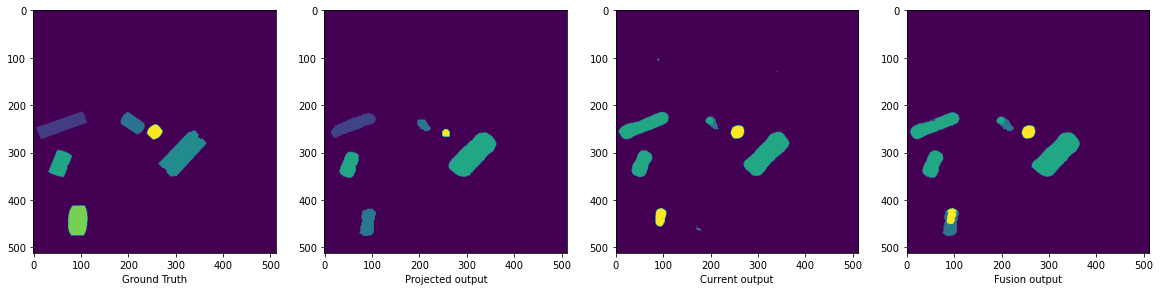

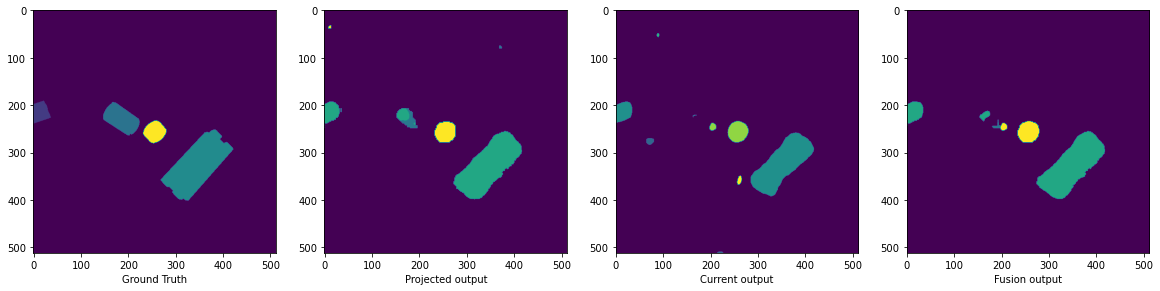

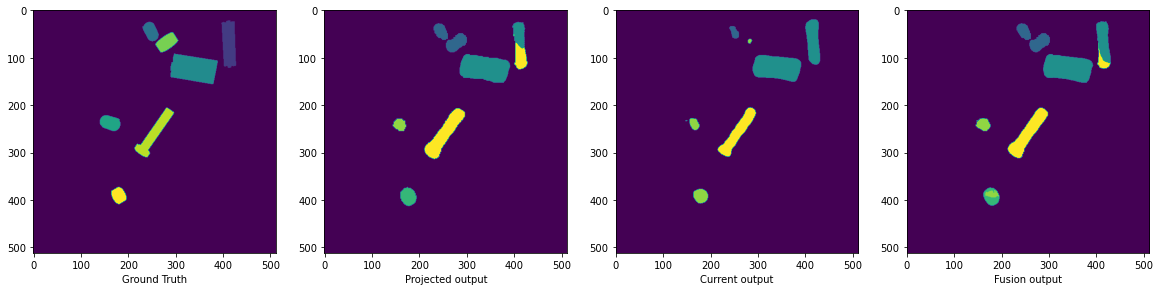

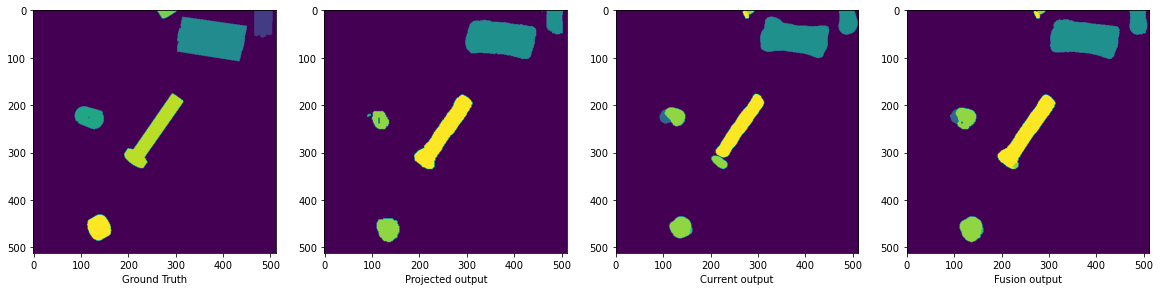

In [10]:

for filename in filenames:
    if (int(os.path.splitext(filename)[0])%3 == 0):
        old_pose_flag = None
        old_pose = None
        old_image = None
        old_depth = None
        old_seg = None
        print ("in")
        
    if int(os.path.splitext(filename)[0]) == 6:
        break
    
    file_path = os.path.join(files_directory, filename)

    with h5py.File(file_path, 'r') as data:
        print ("###### ", os.path.splitext(filename)[0])
        image = np.array(data['colors'])
        print ("image shape ", image.shape)
        true_mask = np.array(data['class_segmaps'])
        print ("mask shape ", true_mask.shape)
        depth = np.array(data['depth'])
        print ("depth  shape ", depth.shape)

        # List all groups
        # List all groups
        print("Keys: %s" % data.keys())
        transformation_matrix = json.loads(np.array(data['camera_pose']).item().decode()) 
        print (transformation_matrix['cam_K'])
        R = np.array(transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(transformation_matrix['cam_t_w2c']).reshape(3,1)
        print ("current T ", T)
        current_pose = np.hstack((R,T))
        current_pose = np.vstack((current_pose,[0., 0., 0., 1.]))
        
        print ("Img shape ", image.shape )#reuturns [100,100,3] a 3 channel image with 100x100 resolution
        image = np.transpose(image,(2,0,1))
        print ("Img shape ", image.shape ) #returns [3,100,100] 
        #convert the numpy array to tensor
        image_tensor = torch.from_numpy(image)
        #rescale to be [0,1] like the data it was trained on by default 
        #image_tensor *= (1/255)
        #turn the tensor into a batch of size 1
        image_tensor = image_tensor.unsqueeze(0)
        
        
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params('resnet34')
        std = torch.tensor(params["std"]).view(1, 3, 1, 1)
        mean = torch.tensor(params["mean"]).view(1, 3, 1, 1)
        
        #send image to gpu 
        #image_tensor.to(device)
        
        # normalize image here
        image_tensor = (image_tensor - mean) / std
        logits = model(image_tensor)
        evidence  = torch.relu(logits)
        mask = evidence + 1
        #turn back  tensor from batch size
        mask = mask.squeeze(0)
        mask = mask.detach().numpy()
        mask = np.transpose(mask,(1,2,0))
        print (" model output shape ", mask.shape)
        
        if old_pose_flag:
            print ("call")
            dst = transform_segmask(transformation_matrix['cam_K'], 
                              old_pose, current_pose, old_seg, old_depth)
            
            added_dst = dst + mask
            print ("added dst shape", added_dst.shape)
        
            #plotting
            plt.figure(figsize=(20, 10))
            ax = plt.subplot(1, 4, 1)
            #plt.imshow(old_seg.argmax(axis=2))
            plt.imshow(true_mask)
            plt.xlabel('Ground Truth')           
            ax = plt.subplot(1, 4, 2)
            plt.imshow(dst.argmax(axis=2))
            plt.xlabel('Projected output')           
            ax = plt.subplot(1, 4, 3)
            plt.imshow(mask.argmax(axis=2))
            plt.xlabel('Current output')
            ax = plt.subplot(1, 4, 4)
            plt.imshow(added_dst.argmax(axis=2))
            plt.xlabel('Fusion output')
            #np.save('old_depth.npy', old_depth)
            #np.save('old_seg.npy', old_seg)
            #np.save('current_seg.npy', mask)
        else:
            old_pose_flag = True
            
        old_pose = current_pose
        old_image = image
        old_depth = depth
        old_seg = mask
        

-----------

## Tensor

In [5]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import h5py

from pprint import pprint
from torch.utils.data import DataLoader
import shutil
import numpy as np
import re 

from PIL import Image
from tqdm import tqdm
from urllib.request import urlretrieve
import json

from pytransform3d.transform_manager import TransformManager


### Dataloader Sequence

In [6]:

class RoboCupDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):

        assert mode in {"train", "valid", "test", "two_sequence", "three_sequence"}

        self.root = root
        self.mode = mode
        self.transform = transform

        self.files_directory = self.root

        self.filenames = self._read_split()  # read train/valid/test splits
        
        self.classes = {0:0,  40:1, 88:2, 112:3, 136:4, 184:5, 208:6, 232:7}
        
        #Saving Camera Matrix K and its inverse
        if self.mode ==  "train" or self.mode == "valid": 
            filename = self.filenames[0]
        elif self.mode == "two_sequence" or self.mode == "three_sequence":
            filename = self.filenames[0][0]
        print ("filename ", filename)
        file_path = os.path.join(self.files_directory, filename)

        with h5py.File(file_path, 'r') as data:
            transformation_matrix = json.loads(np.array(data['camera_pose']).item().decode()) 
            
        self.K = np.array(transformation_matrix['cam_K']).reshape(3,3)
        self.Kinv= np.linalg.inv(self.K)

        

    def __len__(self):
        return len(self.filenames)

    
    @staticmethod
    def _give_rotation_translation(old_transformation_matrix,
                                 new_transformation_matrix):
        R = np.array(old_transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(old_transformation_matrix['cam_t_w2c']).reshape(3,1)
        old_pose = np.hstack((R,T))
        old_pose = np.vstack((old_pose,[0., 0., 0., 1.]))
        
        R = np.array(new_transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(new_transformation_matrix['cam_t_w2c']).reshape(3,1)
        new_pose = np.hstack((R,T))
        new_pose = np.vstack((new_pose,[0., 0., 0., 1.]))
        
        tm = TransformManager()
        tm.add_transform("world", "old_pose", old_pose)
        tm.add_transform("world", "new_pose", new_pose)
        old2new = tm.get_transform("old_pose", "new_pose")
        R = old2new[:3,:3]
        T = old2new[:3,3].reshape(3,1)
        return R, T
    
    def __getitem__(self, idx):

        if self.mode == "train" or self.mode == "valid": 
            filename = self.filenames[idx]
            file_path = os.path.join(self.files_directory, filename)

            with h5py.File(file_path, 'r') as data: 
                image = np.array(data['colors'])
                mask = np.array(data['class_segmaps'])


            #trimap = np.array(Image.open(mask_path))
            mask = self._preprocess_mask(mask)

            sample = dict(image=image, mask=mask)
            if self.transform is not None:
                sample = self.transform(**sample)
        elif self.mode == "two_sequence" or self.mode == "three_sequence":
            #For sequence
            # send all the n images
            # only last frame maske
            # all the poses 
            seq_filenames = self.filenames[idx]
            
            images = []
            maskes = []
            depths = []
            transformation_matrices = []
            for filename in seq_filenames:
                file_path = os.path.join(self.files_directory, filename)

                with h5py.File(file_path, 'r') as data: 
                    images.append(np.array(data['colors']))
                    mask = np.array(data['class_segmaps'])
                    depths.append(np.array(data['depth']))
                    transformation_matrices.append(json.loads(np.array(data['camera_pose']).item().decode()))

                #trimap = np.array(Image.open(mask_path))
                maskes.append( self._preprocess_mask(mask))

            sample = dict(image=images, mask=maskes, transformation_matrix=transformation_matrices)
            
            if self.mode == "two_sequence":
                rotation_old_to_new_camera_frame, \
                translation_old_to_new_camera_frame = self._give_rotation_translation(transformation_matrices[0], 
                                                                                  transformation_matrices[1])
                sample = dict(image0 = images[0],
                              depth0 = depths[0],
                              image1 = images[1], 
                              mask0 = maskes[0], 
                              mask1 = maskes[1], 
                              rotation_old_to_new_camera_frame = rotation_old_to_new_camera_frame,
                              translation_old_to_new_camera_frame = translation_old_to_new_camera_frame)
            elif self.mode == "three_sequence":
                raise NotImplemented

        else:
            raise NotImplementedError("check mode variable while instantiating")

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        classes = {0:0,  40:1, 88:2, 112:3, 136:4, 184:5, 208:6, 232:7}
        mask = mask.astype(np.float32)
        #Remove this and do it in before loading data and save as h5p5
        for c in classes:
            mask[mask==c] = classes[c]

        return mask
    
    
    
    
    def _read_split(self):
        def _atoi(text):
            return int(text) if text.isdigit() else text

        def _natural_keys(text):
            '''
            alist.sort(key=natural_keys) sorts in human order
            http://nedbatchelder.com/blog/200712/human_sorting.html
            (See Toothy's implementation in the comments)
            '''
            return [ _atoi(c) for c in  text.split('.') ]

        
        filenames = [f for f in os.listdir(self.files_directory) if os.path.isfile(os.path.join(self.files_directory, f))]
        
        if self.mode == "train":  # 90% for train
            filenames = [x for i, x in enumerate(filenames) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            filenames = [x for i, x in enumerate(filenames) if i % 10 == 0]
        elif self.mode == "three_sequence": 
            #Sorting files as per the numbering
            # Assumption that files are numbered '0.hdf5', '1.hdf5', '10.hdf5', '
            # Assumption there is 3 images in sequnce starting from 0 
            filenames.sort(key=_natural_keys)
            
            filenames = [[filenames[i+n] for n in range(3)] 
                         for i, x in enumerate(filenames) if i % 3 == 0]
        elif self.mode == "two_sequence": 
            #Sorting files as per the numbering
            # Assumption that files are numbered '0.hdf5', '1.hdf5', '10.hdf5', '
            filenames.sort(key=_natural_keys)
            
            # 3 camera poses can be divided into 2 frames each
            # for example 1 - 2- 3 images
            # can be divided in to [1,2] and [2,3] sequence
            filenames = [[filenames[i+j+n] for n in range(2)] 
                         for i, x in enumerate(filenames) if i % 3 == 0
                         for j in range(2)] 
                        
            print( filenames)
        return filenames


class SequenceRoboCupDataset(RoboCupDataset):
    def __getitem__(self, *args, **kwargs):

        sample = super().__getitem__(*args, **kwargs)
        
        
        # resize images
        image0 = np.array(Image.fromarray(sample["image0"]).resize((512, 512), Image.LINEAR))
        image1 = np.array(Image.fromarray(sample["image1"]).resize((512, 512), Image.LINEAR))
        mask0 = np.array(Image.fromarray(sample["mask0"]).resize((512, 512), Image.NEAREST))
        mask1 = np.array(Image.fromarray(sample["mask1"]).resize((512, 512), Image.NEAREST))


        # convert to other format HWC -> CHW
        sample["image0"] = np.moveaxis(image0, -1, 0)
        sample["image1"] = np.moveaxis(image1, -1, 0)
        sample["mask0"] = np.expand_dims(mask0, 0)
        sample["mask1"] = np.expand_dims(mask1, 0)

        return sample


In [13]:
root = '../learning_blenerproc/images_pose_robocup/'

valid_dataset = SequenceRoboCupDataset(root, "two_sequence")
valid_dataloader = DataLoader(valid_dataset, batch_size=10, shuffle=True, num_workers=int(16/2))


[['0000.hdf5', '0001.hdf5'], ['0001.hdf5', '0002.hdf5'], ['0003.hdf5', '0004.hdf5'], ['0004.hdf5', '0005.hdf5'], ['0006.hdf5', '0007.hdf5'], ['0007.hdf5', '0008.hdf5'], ['0009.hdf5', '0010.hdf5'], ['0010.hdf5', '0011.hdf5'], ['0012.hdf5', '0013.hdf5'], ['0013.hdf5', '0014.hdf5'], ['0015.hdf5', '0016.hdf5'], ['0016.hdf5', '0017.hdf5'], ['0018.hdf5', '0019.hdf5'], ['0019.hdf5', '0020.hdf5'], ['0021.hdf5', '0022.hdf5'], ['0022.hdf5', '0023.hdf5'], ['0024.hdf5', '0025.hdf5'], ['0025.hdf5', '0026.hdf5'], ['0027.hdf5', '0028.hdf5'], ['0028.hdf5', '0029.hdf5'], ['0030.hdf5', '0031.hdf5'], ['0031.hdf5', '0032.hdf5'], ['0033.hdf5', '0034.hdf5'], ['0034.hdf5', '0035.hdf5'], ['0036.hdf5', '0037.hdf5'], ['0037.hdf5', '0038.hdf5'], ['0039.hdf5', '0040.hdf5'], ['0040.hdf5', '0041.hdf5'], ['0042.hdf5', '0043.hdf5'], ['0043.hdf5', '0044.hdf5'], ['0045.hdf5', '0046.hdf5'], ['0046.hdf5', '0047.hdf5'], ['0048.hdf5', '0049.hdf5'], ['0049.hdf5', '0050.hdf5'], ['0051.hdf5', '0052.hdf5'], ['0052.hdf5', '0053

In [50]:
sample = valid_dataset[0]
np.unique(sample["mask0"], return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32),
 array([253267,   1477,    769,   2459,    922,   1085,   1760,    405]))

### Fusion

In [12]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import h5py
import torch 
import torch.nn.functional as F
import evidence_loss
from torch.nn.functional import interpolate

### Only mask1 validation code


In [9]:

class SequenceRoboCupModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn_without_background = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True, 
                                                              ignore_index=0.0)
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
        self.n_classes = out_classes
        
        self.epoch = 0
        self.ignore_class = 0.0 #ignore background class  fr loss function


    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask
    
        

    def shared_step(self, batch, stage):
        image0 = batch["image0"]
        image1 = batch["image1"]
        depth0 = batch["depth0"]
        

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image0.ndim == 4
        
        bs, num_channels, height, width = image0.size()

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image0.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask0 = batch["mask0"]
        mask1 = batch["mask1"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask0.ndim == 4
        assert mask1.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask0.max() <= 255.0 and mask0.min() >= 0
        assert mask1.max() <= 255.0 and mask1.min() >= 0

        logits_mask1 = self.forward(image1)
        
        #unroll the tensor to single tensor 
        # [batch_size, 1, height, width] -> [batch_size*height*width]
        mask1 = torch.ravel(mask1)
        
        #Remove pixels exculding the background loss function
        idx_only_objects = mask1 != self.ignore_class
        
        
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True       
        mask1 = F.one_hot(mask1.to(torch.long), self.n_classes)  # [batch_size*height*width] -> [batch_size*height*width, n_classes]
        
        # [batch_size, n_classes, height, width] -> [batch_size,n_classes, height*width]
        logits_mask1 = logits_mask1.view(bs, self.n_classes, -1) 
        # [batch_size,n_classes, height*width] -> [batch_size, height*width, n_classes]
        logits_mask1 = logits_mask1.permute(0,2,1)
        # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
        logits_mask1 = logits_mask1.reshape_as(mask1)
        
       

        #Fluctute between all loss and only objects loss excluding bakground
        if (stage == "train"):
            if self.epoch % 3 == 0:
                loss = evidence_loss.edl_mse_loss(logits_mask1, mask1, self.epoch, self.n_classes, 10)
            else:
                loss = evidence_loss.edl_mse_loss(logits_mask1[idx_only_objects], mask1[idx_only_objects], self.epoch, self.n_classes, 10)
        else:
            loss = evidence_loss.edl_mse_loss(logits_mask1[idx_only_objects], mask1[idx_only_objects], self.epoch, self.n_classes, 10)

     

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        #prob_mask = logits_mask.sigmoid()
        #pred_mask = (prob_mask > 0.5).float()
        prob_mask = logits_mask1.log_softmax(dim=1).exp()
        pred_mask = prob_mask.argmax(dim=1, keepdim=True)
        #print ("prob mask ",prob_mask.shape)
        #print ("pred mask ",pred_mask.shape)
        #print (" mask ", mask.shape)
          
        #Changing back to original dimension for metrics calculation
        mask1 = mask1.argmax(dim=1, keepdim=True)
        pred_mask = pred_mask.reshape(bs, 1, height, width )
        mask1 = mask1.reshape(bs, 1, height, width)
        
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask1.long(), mode="multiclass", 
                                               num_classes=self.n_classes)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):

        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        # aggregate step metics
        loss = [x["loss"].item() for x in outputs]
        

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_evidential_loss": np.mean(loss)
        }
        
        self.log_dict(metrics, prog_bar=True)
        self.epoch += 1

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

------

In [58]:
model = SequenceRoboCupModel("FPN", "resnet34", in_channels=3, out_classes=8)
model.model = torch.load('uncertain_semantic_resnet_34_200epoch.pt')

In [59]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=200,
)
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

0.9038875102996826
0.7616040706634521
0.796037495136261
0.9060971736907959
0.7640198469161987
0.8061969876289368
0.9115097522735596
0.7658460736274719
0.734321653842926
0.7172811627388
[{'valid_dataset_iou': 0.9078928232192993,
  'valid_evidential_loss': 0.8066802024841309,
  'valid_per_image_iou': 0.9095935821533203}]


-----

### Validation with both mask1 and mask 0 


In [47]:

class SequenceRoboCupModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, 
                 K, Kinv, combine_method, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.combine_method = combine_method
        self.n_classes = out_classes
        
        self.epoch = 0
        self.ignore_class = 0.0 #ignore background class  fr loss function
        
        self.K = K 
        self.Kinv = Kinv
        
        self.confmat = ConfusionMatrix(num_classes=out_classes, normalize='pred')


    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask
    
    def dempster_schafer_combine(self, alpha1, alpha2):
        # Calculate the merger of two DS evidences
        alpha = dict()
        alpha[0], alpha[1] = alpha1, alpha2
        b, S, E, u = dict(), dict(), dict(), dict()
        for v in range(2):
            S[v] = torch.sum(alpha[v], dim=1, keepdim=True)
            E[v] = alpha[v] - 1
            b[v] = E[v] / (S[v].expand(E[v].shape))
            u[v] = self.n_classes / S[v]

        # b^0 @ b^(0+1)
        bb = torch.bmm(b[0].view(-1, self.n_classes, 1), b[1].view(-1, 1, self.n_classes))
        # b^0 * u^1
        uv1_expand = u[1].expand(b[0].shape)
        bu = torch.mul(b[0], uv1_expand)
        # b^1 * u^0
        uv_expand = u[0].expand(b[0].shape)
        ub = torch.mul(b[1], uv_expand)
        # calculate K
        bb_sum = torch.sum(bb, dim=(1, 2), out=None)
        bb_diag = torch.diagonal(bb, dim1=-2, dim2=-1).sum(-1)
        # bb_diag1 = torch.diag(torch.mm(b[v], torch.transpose(b[v+1], 0, 1)))
        K = bb_sum - bb_diag

        # calculate b^a
        b_a = (torch.mul(b[0], b[1]) + bu + ub) / ((1 - K).view(-1, 1).expand(b[0].shape))
        # calculate u^a
        u_a = torch.mul(u[0], u[1]) / ((1 - K).view(-1, 1).expand(u[0].shape))
        # test = torch.sum(b_a, dim = 1, keepdim = True) + u_a #Verify programming errors

        # calculate new S
        S_a = self.n_classes / u_a
        # calculate new e_k
        e_a = torch.mul(b_a, S_a.expand(b_a.shape))
        alpha_a = e_a + 1
        return alpha_a
    
    def epipolar_propagate(self, batch, logits):
        bs, num_channels, height, width = batch['image0'].size()
        
        #Getting depth and flatenning it and making it [n, 1, height*width] shape
        flattened_depth = torch.flatten(batch['depth0'], start_dim=1)
        flattened_depth = torch.unsqueeze(flattened_depth, dim=1).float()

        #Getting Transformation and Rotation from previous frame
        T = batch['translation_old_to_new_camera_frame'].float().to(self.device)
        R = batch['rotation_old_to_new_camera_frame'].float().to(self.device)

        #Getting index of each pixel of image in [n,3, height*width] shape device=self.device
        grid_x, grid_y = torch.meshgrid(torch.arange(height, device=self.device), 
                                        torch.arange(width, device=self.device), indexing='ij')
        grid_x = torch.flatten(grid_x, start_dim=0)
        grid_y = torch.flatten(grid_y, start_dim=0)
        ## Stacking to make the matrix 3 x points
        index = torch.vstack((grid_x, grid_y, torch.ones_like(grid_y))).float()

        #Camera intrinsics
        K = torch.tensor(self.K, device=self.device).float().to(self.device)
        Kinv = torch.tensor(self.Kinv, device=self.device).float().to(self.device)

        #Epipolar Geometry
        transposed_index = torch.matmul(torch.matmul(torch.matmul(K, R), Kinv), index) + torch.matmul(K,torch.div(T, flattened_depth))
        ## Dividing Last column for each image
        transposed_index = torch.div(transposed_index, transposed_index[:,2,:].unsqueeze(1))
        ## Clamping index
        transposed_index = torch.clamp(transposed_index, min=0, max=511).long() # imagesize is 512 ,  1 
        #Projecting pixels from previous frame based on the transposed index
        projected_tensor = torch.zeros_like(logits, device=self.device)

        #ToDo can this be done without for loop
        for i,p in enumerate(transposed_index):
            projected_tensor[i,:,p[0],p[1]] = logits[i,:,grid_x, grid_y]

        projected_tensor = projected_tensor.float()
        #m = torch.nn.MaxPool2d(2)
        projected_tensor = F.max_pool2d(projected_tensor, kernel_size=2)

        projected_tensor = interpolate(projected_tensor, scale_factor=2 )
        
        return projected_tensor

    def shared_step(self, batch, stage):
        image0 = batch["image0"]
        image1 = batch["image1"]
        depth0 = batch["depth0"]
        

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image0.ndim == 4
        
        bs, num_channels, height, width = image0.size()

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image0.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask0 = batch["mask0"]
        mask1 = batch["mask1"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask0.ndim == 4
        assert mask1.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask0.max() <= 255.0 and mask0.min() >= 0
        assert mask1.max() <= 255.0 and mask1.min() >= 0

        logits_mask0 = self.forward(image0)
        propagate_mask0 = self.epipolar_propagate(batch, logits_mask0)
        
        logits_mask1 = self.forward(image1)
      
        #combining evidence
        if "sum" == self.combine_method:
            logits_mask1 = logits_mask1 + propagate_mask0
            prob_mask = logits_mask1.log_softmax(dim=1).exp()
        elif "belief_sum" == self.combine_method:
            logits_mask1 = self.dempster_schafer_combine(torch.relu(logits_mask1) + 1,
                                                         torch.relu(propagate_mask0) + 1)
        elif "bayesian" == self.combine_method:
            raise NotImplemented
        else:
            raise Exception("Please define combine method") 
        
        #unroll the tensor to single tensor 
        # [batch_size, 1, height, width] -> [batch_size*height*width]
        mask1 = torch.ravel(mask1)      
        #Remove pixels exculding the background loss function
        idx_only_objects = mask1 != self.ignore_class      
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True       
        mask1 = F.one_hot(mask1.long(), self.n_classes)  # [batch_size*height*width] -> [batch_size*height*width, n_classes]
        
        # [batch_size, n_classes, height, width] -> [batch_size,n_classes, height*width]
        logits_mask1 = logits_mask1.view(bs, self.n_classes, -1)
        # [batch_size,n_classes, height*width] -> [batch_size, height*width, n_classes]
        logits_mask1 = logits_mask1.permute(0,2,1)
        # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
        logits_mask1 = logits_mask1.reshape_as(mask1)        
        
        #Fluctute between all loss and only objects loss excluding bakground
        if (stage == "train"):
            if self.epoch % 3 == 0:
                loss = evidence_loss.edl_mse_loss(logits_mask1, mask1, self.epoch, self.n_classes, 10)
            else:
                loss = evidence_loss.edl_mse_loss(logits_mask1[idx_only_objects], mask1[idx_only_objects], self.epoch, self.n_classes, 10)
        else:
            loss = evidence_loss.edl_mse_loss(logits_mask1[idx_only_objects], 
                                              mask1[idx_only_objects], 
                                              self.epoch, self.n_classes, 10)

     

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        
         #combining evidence
        if "sum" == self.combine_method:
            prob_mask = logits_mask1.log_softmax(dim=1).exp()
            
        pred_mask = prob_mask.argmax(dim=1, keepdim=True)
         
        #Changing back to original dimension for metrics calculation
        mask1 = mask1.argmax(dim=1, keepdim=True)
        
        #Confusion matrix calculation
        confusion_matrix = self.confmat(pred_mask, mask1)
        
        pred_mask = pred_mask.reshape(bs, 1, height, width )
        mask1 = mask1.reshape(bs, 1, height, width)
        
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(),
                                               mask1.long(), 
                                               mode="multiclass", 
                                               num_classes=self.n_classes)
       
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "confusion_matrix":confusion_matrix
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        # then compute metrics with required reduction (see metric docs)
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        # aggregate step metics
        loss = [x["loss"].item() for x in outputs]
        
        #confusion matrix sum
        self.cm = torch.sum(torch.stack([x["confusion_matrix"] for x in outputs]), dim=0)
        print (self.cm.shape)

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_evidential_loss": np.mean(loss)
        }
        
        self.log_dict(metrics, prog_bar=True)
        self.epoch += 1

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [48]:
model = SequenceRoboCupModel("FPN", "resnet34", in_channels=3, out_classes=8, combine_method='sum',
                            K=valid_dataset.K, Kinv=valid_dataset.Kinv)
model.model = torch.load('uncertain_semantic_resnet_34_200epoch.pt')
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=200,
)
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

/home/deebuls/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 8 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


torch.Size([8, 8])
[{'valid_dataset_iou': 0.9173896908760071,
  'valid_evidential_loss': 0.7312204837799072,
  'valid_per_image_iou': 0.9186875224113464}]


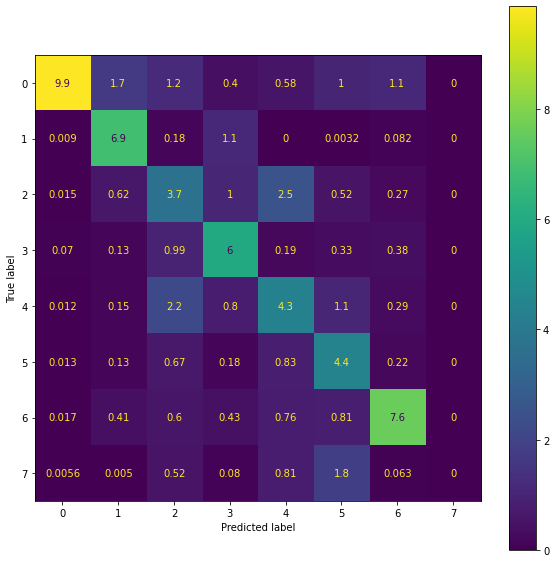

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(model.cm.cpu().detach().numpy())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

In [11]:
model = SequenceRoboCupModel("FPN", "resnet34", in_channels=3, out_classes=8, combine_method='belief_sum')
model.model = torch.load('uncertain_semantic_resnet_34_200epoch.pt')
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=200,
)
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/deebuls/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:453: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

NameError: name 'train_dataset' is not defined

In [ ]:
class EpipolarPropagate(nn.Module):
    def __init__(self):
        super(EpipolarPropagate, self).__init__()
        
        
        
    def forward(self, D, Y):
        

In [ ]:
for d in tqdm(valid_dataloader):
    image1 = batch["image1"]

In [39]:
for batch in tqdm(valid_dataloader):
    #Getting depth and flatenning it and making it [n, 1, height*width] shape
    flattened_depth = torch.flatten(batch['depth0'], start_dim=1)
    flattened_depth = torch.unsqueeze(flattened_depth, dim=1).float()
    
    #Getting Transformation and Rotation from previous frame
    T = batch['translation_old_to_new_camera_frame'].float()
    R = batch['rotation_old_to_new_camera_frame'].float()
    
    #Getting index of each pixel of image in [n,3, height*width] shape
    height,width  = 512, 512
    grid_x, grid_y = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
    grid_x = torch.flatten(grid_x, start_dim=0)
    grid_y = torch.flatten(grid_y, start_dim=0)
    ## Stacking to make the matrix 3 x points
    index = torch.vstack((grid_x, grid_y, torch.ones_like(grid_y))).float()
    
    #Camera intrinsics
    K = torch.tensor(train_dataset.K).float()
    Kinv = torch.tensor(train_dataset.Kinv).float()

    #Epipolar Geometry
    transposed_index = torch.matmul(torch.matmul(torch.matmul(K, R), Kinv), index) + torch.matmul(K,torch.div(T, flattened_depth))
    ## Dividing Last column for each image
    transposed_index = torch.div(transposed_index, transposed_index[:,2,:].unsqueeze(1))
    ## Clamping index
    transposed_index = torch.clamp(transposed_index, min=0, max=511).type(torch.LongTensor) # imagesize is 512 ,  1 
    
    #Projecting pixels from previous frame based on the transposed index
    xdst = torch.zeros_like(batch['mask0'])
    
    #ToDo can this be done without for loop
    for i,p in enumerate(transposed_index):
        xdst[i,:,p[0],p[1]] = batch['mask0'][i,:,grid_x, grid_y]
        
    projected_tensor = xdst.type(torch.FloatTensor)
    #m = torch.nn.MaxPool2d(2)
    projected_tensor = F.max_pool2d(projected_tensor, kernel_size=2)

    projected_tensor = interpolate(projected_tensor, scale_factor=2 )


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.67it/s]


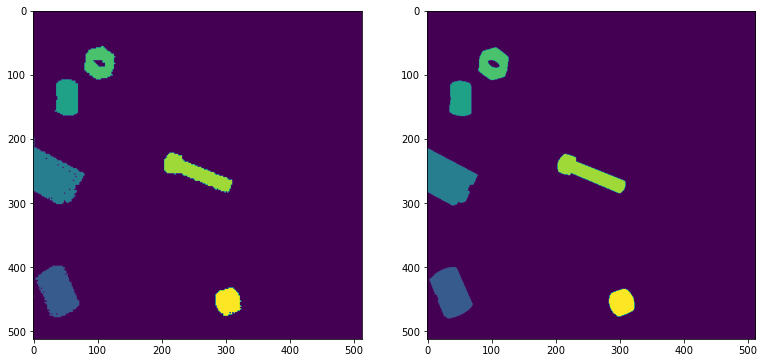

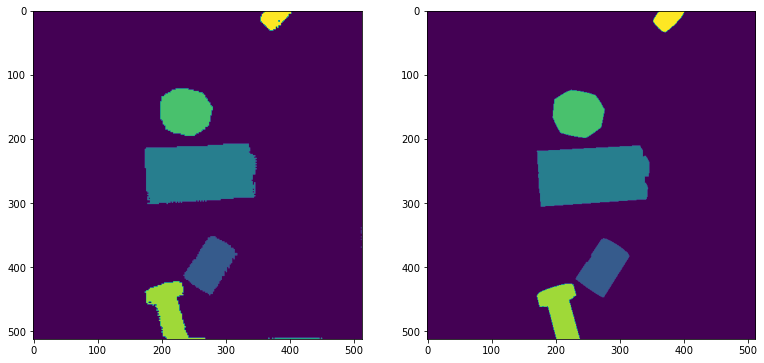

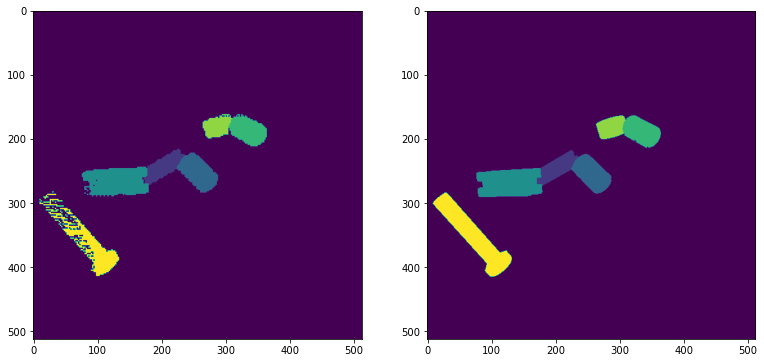

In [41]:
for i in range(3):
    x = projected_tensor[i].detach().numpy()
    x = np.transpose(x,(1,2,0))
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(x)
    ax = plt.subplot(1, 3, 2)

    mask1 = batch['mask1'][i].detach().numpy()
    mask1 = np.transpose(mask1,(1,2,0))
    plt.imshow(mask1)

-------